In this notebook, we apply an ARIMA ($\textbf{A}$uto$\textbf{R}$egressive $\textbf{I}$ntegrative $\textbf{M}$oving $\textbf{A}$verage) model to crypto data. A large amount of inspiration for this model was taken from https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70 and the Investopedia article.

In [1]:
# First, we read in our data.

import pandas as pd

df = pd.read_csv("preprocessing/crypto_data.csv")
df.head()

,date,high,low,open,close,volume,adjclose,coin,p
0,1483228800,1003.080017,958.698975,963.658020,998.325012,147775008.0,998.325012,BTC-USD,1.035974
1,1483315200,1031.390015,996.702026,998.617004,1021.750000,222184992.0,1021.750000,BTC-USD,1.023165
2,1483401600,1044.079956,1021.599976,1021.599976,1043.839966,185168000.0,1043.839966,BTC-USD,1.021770
3,1483488000,1159.420044,1044.400024,1044.400024,1154.729980,344945984.0,1154.729980,BTC-USD,1.105640
4,1483574400,1191.099976,910.416992,1156.729980,1013.380005,510199008.0,1013.380005,BTC-USD,0.876073


In [2]:
coins = df['coin'].unique()
coins

array(['BTC-USD', 'ETH-USD', 'SOL1-USD', 'BNB-USD', 'DOT1-USD', 'ADA-USD',
       'XRP-USD', 'DOGE-USD', 'SHIB-USD', 'AVAX-USD', 'LTC-USD',
       'XMR-USD', 'ETC-USD', 'REP-USD', 'MAID-USD', 'STEEM-USD'],
      dtype=object)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


Much like the TowardsDataScience article, we target the $\textbf{close}$ column to predict for. We begin by performing some EDA - for the sake of simplicity, we simply target BTC-USD - plotting autocorrelations and the trend over time.

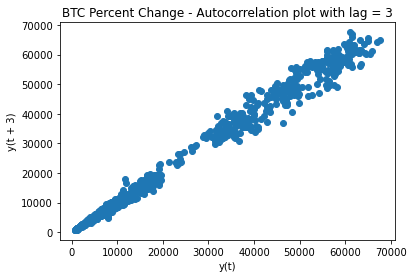

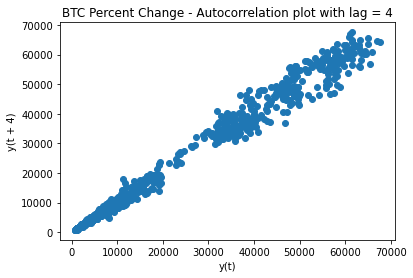

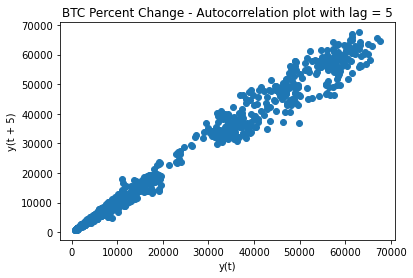

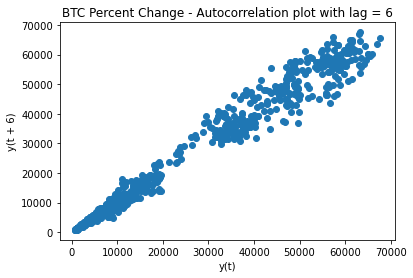

In [4]:
lags = range(3, 7)
for lag in lags:
    plt.figure()
    df_btc_opens = df.loc[df['coin'] == 'BTC-USD', 'close']
    lag_plot(df_btc_opens, lag=lag)
    plt.title('BTC Percent Change - Autocorrelation plot with lag = {}'.format(lag))
    plt.show()

Now, we train our actual ARIMA models. Since we use autocorrelations in ARIMA, we look at coins separately, and our mean-squared error is simply the mean squared error across all coins. We do an exhaustive hyperparameter search for the best values of $p$ and $d$.

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# warnings.simplefilter(action='ignore', category=VisibleDeprecationWarning)
# warnings.simplefilter(action='ignore', category=ConvergenceWarning)

unique_coins = df['coin'].unique()
ps = range(2, 5)
ds = range(1, 3) # note that d = 0 is simply the ARMA model, d>2 is not supported
q = 0
train_fold = 0.85

for p in ps:
    for d in ds:
        coin_mses = []
        for coin in unique_coins:
            df_coin = df.loc[df['coin'] == coin, 'close']
            df_coin_p = df.loc[df['coin'] == coin, 'p']
            train_data_coin = list(df_coin[0: int(len(df_coin) * train_fold)].dropna().values)
            test_data_coin = list(df_coin[int(len(df_coin) * train_fold):].dropna().values)
            train_data_coin.append(test_data_coin[0])
            coin_preds = [0]
            for time_point in range(1, len(test_data_coin)):
                model = ARIMA(train_data_coin, order=(p, d, q))
                model_fit = model.fit(disp=0)
                coin_preds.append((model_fit.forecast()[0] / test_data_coin[time_point - 1])[0])
                train_data_coin.append(test_data_coin[time_point])
            truths = np.array(df_coin_p[int(len(df_coin) * train_fold):].dropna().values)
            tm = truths.mean()
            ts = truths.std()
            truths = (truths - tm) / ts
            coin_preds = (np.array(coin_preds) - tm) / ts
            coin_mses.append(((coin_preds - truths) ** 2).mean())
        print('For p = {}, d = {}, q = {}, mean = {}'.format(str(p), str(d), str(q), str(np.array(coin_mses).mean())))


We see that $p = 2$, $d = 1$ performs best. We plot the prediction curves for the coins here:

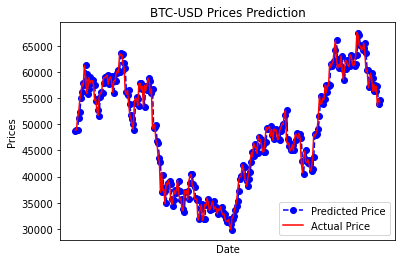

/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


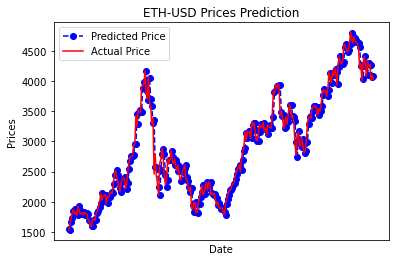

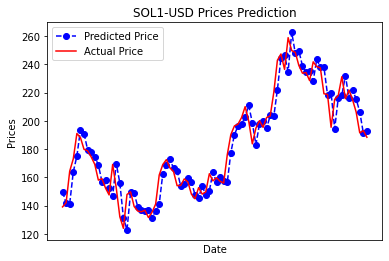

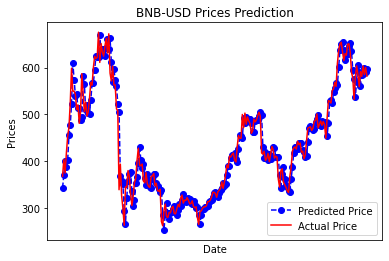

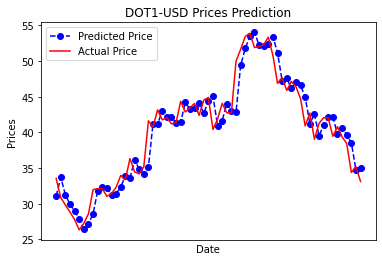

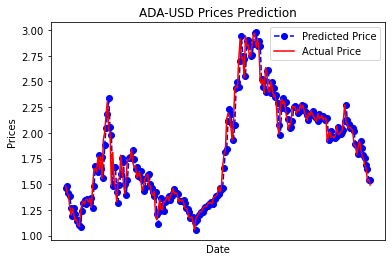

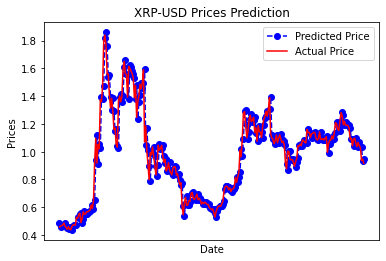

/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


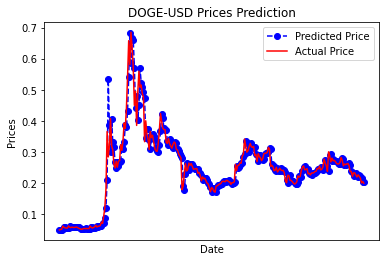

/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Max

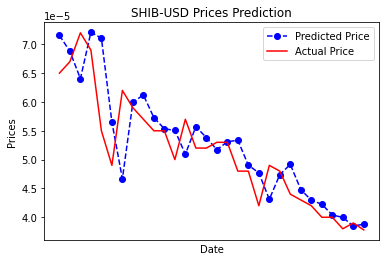

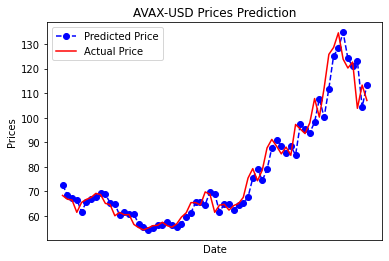

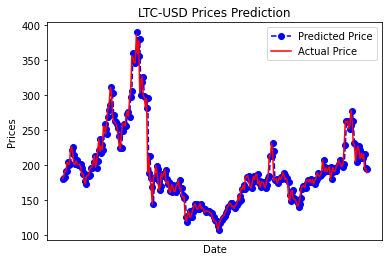

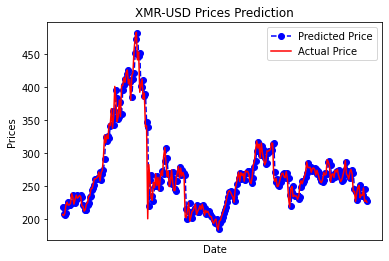

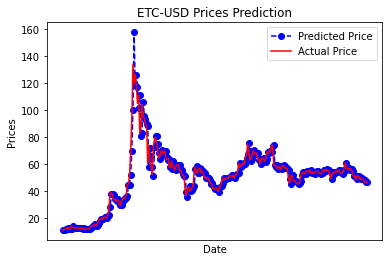

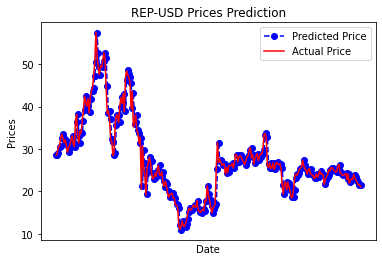

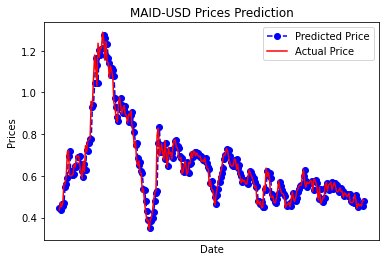

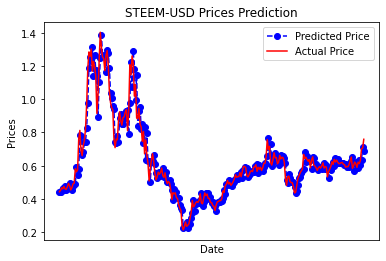

In [13]:
unique_coins = df['coin'].unique()
train_fold = 0.85
for coin in unique_coins:
    df_coin = df.loc[df['coin'] == coin, 'close']
    train_data_coin = list(df_coin[0: int(len(df_coin) * train_fold)].dropna().values)
    test_data_coin = list(df_coin[int(len(df_coin) * train_fold): int(len(df_coin) * (train_fold + .2))].dropna().values)
    coin_preds = []
    for time_point in range(len(test_data_coin)):
        model = ARIMA(train_data_coin, order=(2, 1, 0))
        model_fit = model.fit(disp=0)
        coin_preds.append(model_fit.forecast()[0])
        truth = test_data_coin[time_point]
        train_data_coin.append(truth)
    
    test_set_range = df_coin[int(len(df_coin)* train_fold):].index
    plt.plot(test_set_range, coin_preds, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
    plt.plot(test_set_range, test_data_coin, color='red', label='Actual Price')
    plt.title('{} Prices Prediction'.format(coin))
    plt.xticks([], [])
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

Furthermore, we post the raw MSE scores between the coins and our model with the selected hyperparameters.

In [16]:
p, d, q = 2, 1, 0

unique_coins = df['coin'].unique()
train_fold = 0.85
for coin in unique_coins:
    df_coin = df.loc[df['coin'] == coin, 'close']
    df_coin_p = df_coin_p = df.loc[df['coin'] == coin, 'p']
    train_data_coin = list(df_coin[0: int(len(df_coin) * train_fold)].dropna().values)
    test_data_coin = list(df_coin[int(len(df_coin) * train_fold):].dropna().values)
    train_data_coin.append(test_data_coin[0])
    coin_preds = [0]
    for time_point in range(1, len(test_data_coin)):
        model = ARIMA(train_data_coin, order=(p, d, q))
        model_fit = model.fit(disp=0)
        coin_preds.append((model_fit.forecast()[0] / test_data_coin[time_point - 1])[0])
        train_data_coin.append(test_data_coin[time_point])
    truths = np.array(df_coin_p[int(len(df_coin) * train_fold):].dropna().values)
    tm = truths.mean()
    ts = truths.std()
    truths = (truths - tm) / ts
    coin_preds = (np.array(coin_preds) - tm) / ts
    coin_mses.append(((coin_preds - truths) ** 2).mean())
    print("MSE Loss for {}: {}".format(coin, str(np.array(coin_mses).mean())))

MSE Loss for BTC-USD: 3.1577534467516246


/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MSE Loss for ETH-USD: 3.0819864283150937
MSE Loss for SOL1-USD: 3.136730679262127
MSE Loss for BNB-USD: 3.0685453157850255
MSE Loss for DOT1-USD: 3.2914831581054993
MSE Loss for ADA-USD: 3.2235200612774007
MSE Loss for XRP-USD: 3.1263731091865634


/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MSE Loss for DOGE-USD: 3.030536818172399


/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/dannytse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Max

MSE Loss for SHIB-USD: 3.089509997233987
MSE Loss for AVAX-USD: 3.2016669772869877
MSE Loss for LTC-USD: 3.1436040600667234
MSE Loss for XMR-USD: 3.083010608100732
MSE Loss for ETC-USD: 3.017553881874739
MSE Loss for REP-USD: 2.952752410249041
MSE Loss for MAID-USD: 2.9006996196862236
MSE Loss for STEEM-USD: 2.852615877388885
